In [39]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
#ACOLLINEARITY FUNCTION
def angleacoll(th1,th2,ph1,ph2):
    v1=[np.sin(th1)*np.cos(ph1),np.sin(th1)*np.sin(ph1),np.cos(th1)]
    v2=[np.sin(th2)*np.cos(ph2),np.sin(th2)*np.sin(ph2),np.cos(th2)]
    dot = np.dot(v1,v2)
    return (abs(np.pi-np.arccos(dot)))



#function that finds number of events in dataframe
#it identifies an events by pair event number and run number
def n_events(df):
    sumev = 0
    for item in df.groupby(['ievt', 'irun']).size():
        sumev = sumev + item
    return sumev

#find corresponding cross section given the channel
def dfxsec(dfname, df_names):
    index = df_names.index(dfname)
    return xsections[index]

#find scale factor by which each channel needs to be multiplied to match data
def scalefactor(lumi, n_events, xsec):
    return (xsec*lumi)/n_events


def LogLR(expBkg, expSig, obs):
    #avoid log of 0 using super small number #hack
    result = obs*np.log(max(expSig+expBkg, 0.000001)) - expSig - obs*np.log(max(expBkg,0.000001))
    return -2*result

In [41]:
#initial definitions


backgrounds = ['eeqq','qq','wen','ww','zee','zz']
backgrounds_cs = [15600,102,2.90,16.5,3.35,0.975] #pb
signals = ['higgs_85','higgs_90','higgs_95']
signal_cs = [0.0940,0.0667,0.0333] #pb
data = ['data']



#concatenate all the channels
channels = backgrounds + signals + data
xsections = backgrounds_cs + signal_cs

#list which takes into account whether the channel is a background (bkg), signal (sgn), or data (data)
bkgsigdata = []

#dataframes lists
df_names = [] #need to work with names instead of just df because python cannot find a dataframe in a list of dataframes, so i just search by name
df_list = []
df_list_cut = []

#factor *signal to make it more visible (accounted for in efficiencies)
pumpsignal = 100    

#integrate luminosity
int_lumi = 176.773 #pb^-1

In [42]:
################################
# creation of all df and lists #
################################



for channel in channels:
    #fill the dataframes
    filename = './l3higgs189/higgs_' + channel + '.csv'
    dfname = 'df_' + channel
    vars()[dfname] = pd.read_csv(filename)
       
    #add recoiling mass against jets
    angle = 180*np.pi/180
    recmass = []
    acollin = []
    for index, row in (vars()[dfname]).iterrows():
        #recoil mass
        '''recoilmass=0
        theta_jets = (row['xmj1']*row['thj1']+row['xmj2']*row['thj2'])/(row['xmj1']+row['xmj2'])
        phi_jets = (row['xmj1']*row['phj1']+row['xmj2']*row['phj2'])/(row['xmj1']+row['xmj2'])
        if ((row['ele_phi'] < phi_jets+np.pi+angle) and (row['ele_phi'] > phi_jets+np.pi-angle) and (row['ele_the'] < theta_jets+np.pi+angle) and (row['ele_the'] > theta_jets+np.pi-angle)):
            recoilmass += 0.000511*row['ele_num']
        if ((row['muon_phi'] < phi_jets+np.pi+angle) and (row['muon_phi'] > phi_jets+np.pi-angle) and (row['muon_the'] < theta_jets+np.pi+angle) and (row['muon_the'] > theta_jets+np.pi-angle)):
            recoilmass += 0.105*row['muon_num']
        recmass.append(recoilmass)'''
        #acollinearity
        acollin.append(angleacoll(row['thj1'],row['thj2'],row['phj1'],row['phj2']))
            
    #(vars()[dfname])['rec_mass'] = recmass
    (vars()[dfname])['acoll'] = acollin
        
    
    
    #fill the bkgsigdata list, categorizing bkg, sgn, data
    if channel in backgrounds:
        bkgsigdata.append('bkg')
    elif channel in signals:
        bkgsigdata.append('sgn')
    elif channel in data:
        bkgsigdata.append('data')
        
    #fill dataframes lists
    df_names.append(dfname)
    df_list.append(vars()[dfname])
    

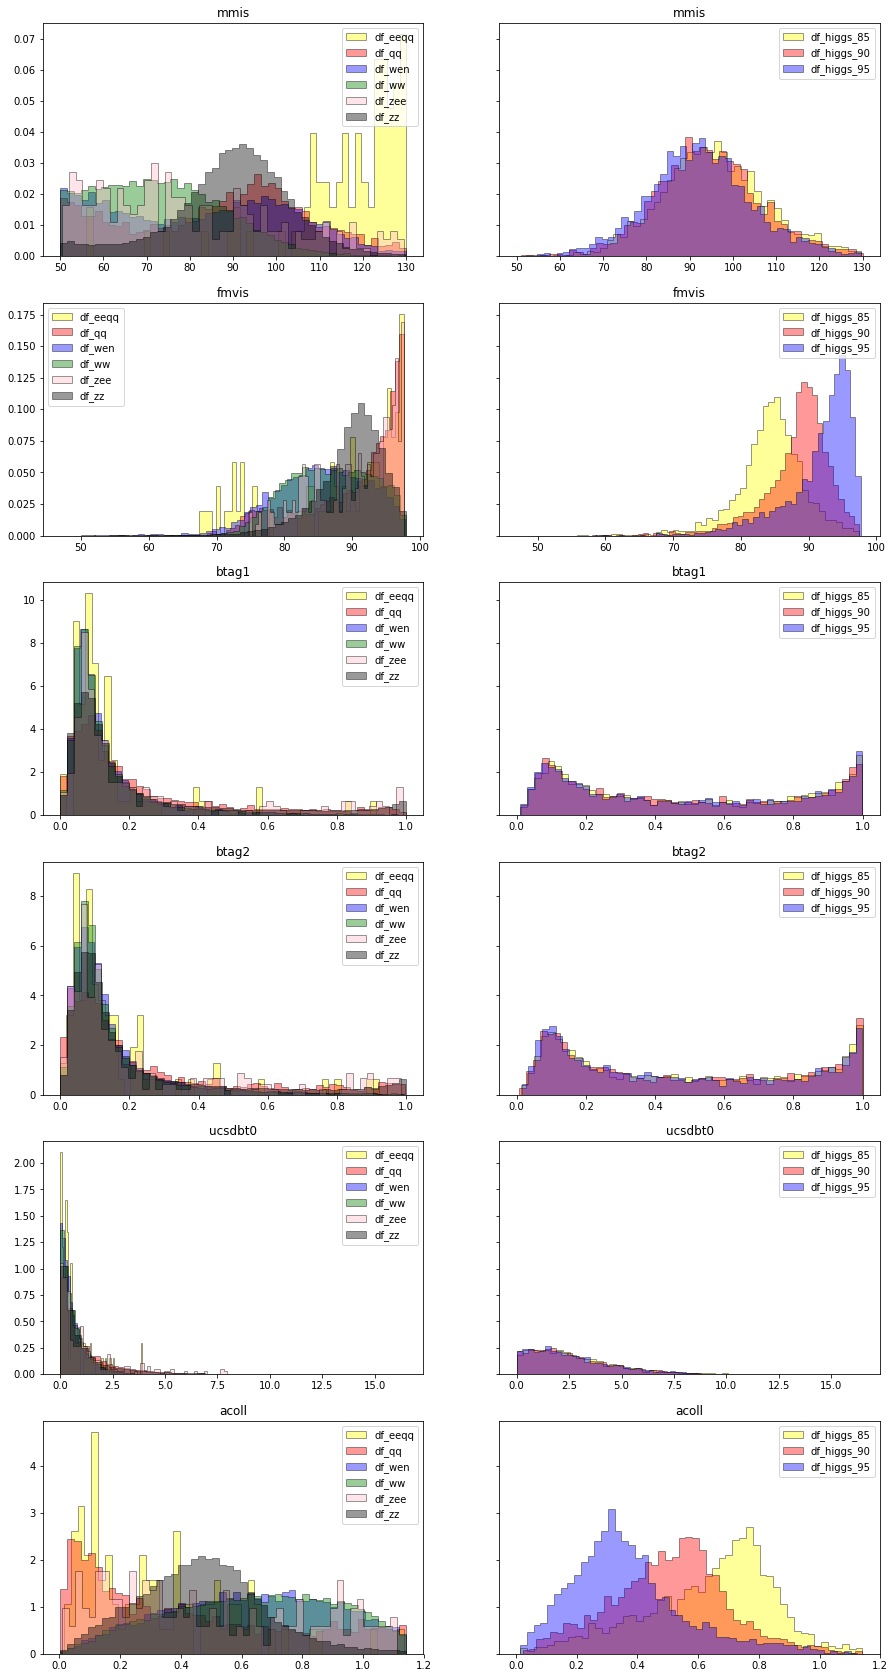

In [44]:
##########################################################
# plot all variables for signal and background (no cuts) #
##########################################################

#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['mmis', 'fmvis', 'btag1', 'btag2', 'ucsdbt0', 'acoll']
#varlist = ['mmis', 'pho_ene']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)

f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

for varname in varlist:
    index_var = varlist.index(varname)
    for dfname in df_names:
        index = df_names.index(dfname)
        
        #backgrounds
        if bkgsigdata[index] == 'bkg':
            #plot histograms (normalised area to 1)
            axs[index_var,0].hist((df_list[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4, density=True)
            
            #calculate scale factor (xs) and plot histograms
            scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events(df_list[index]), n_events(df_list[index])))
            #axs[index_var,0].hist(((df_list[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
        
        #signals
        if bkgsigdata[index] == 'sgn':
            #plot histograms (normalised area to 1)
            axs[index_var,1].hist((df_list[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4, density=True)

            #calculate scale factor (xs) and plot histograms
            scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events(df_list[index]), n_events(df_list[index])))
            #axs[index_var,1].hist(((df_list[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
    
    #plot title and legend for background (left) and signal (right)
    axs[index_var,0].set_title(varname)
    axs[index_var,0].legend(loc='best')
    axs[index_var,1].set_title(varname)
    axs[index_var,1].legend(loc='best')

#plt.show()

In [51]:
#find n of events in signal
for dfname in df_names:
    index = df_names.index(dfname)
    if bkgsigdata[index] == 'sgn':
        scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
        nevents=((n_events(df_list_cut[index]))*scalef)
        print (dfname, nevents)


df_higgs_85 255.71719630181926
df_higgs_90 180.48851139240506
df_higgs_95 82.03134148923446


0.85
0.855
0.86
0.865
0.87
0.875
0.88
0.885
0.89
0.895
0.8999999999999999
0.905
0.9099999999999999
0.9149999999999999
0.9199999999999999
0.9249999999999999
0.9299999999999999
0.9349999999999999
0.94
0.945
0.95


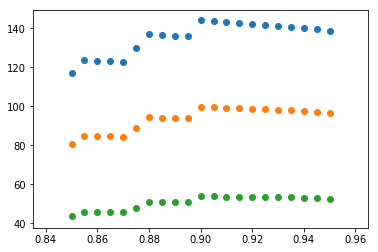

In [68]:
#######################################
# plot efficiency*purity varying cuts #
#######################################


#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['btag1', 'btag2', 'ucsdbt0', 'mmis','acoll', 'mvis']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)
df_list_cut = []

eff_85 = []
eff_90 = []
eff_95 = []
pur_85 = []
pur_90 = []
pur_95 = []
effpur_85 = []
effpur_90 = []
effpur_95 = []

sgn_nocut_85 = 255.71719630181926
sgn_nocut_90 = 180.48851139240506
sgn_nocut_95 = 82.03134148923446

scatterxaxis = []


#btag
xrange_btag = np.linspace(0.85,0.95,21)
#angle acollinaerity
xrange_angle = np.linspace(0,180,19)
#ucsdbt0
xrange_bts = np.linspace(0,14,30)


xrange = xrange_btag
for cutvalue in xrange:
    df_list_cut = []
    print(cutvalue)
    #f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

    for dfname in df_names:
        index = df_names.index(dfname)
        tmpdf = (df_list[index])[(df_list[index])['acoll'] < cutvalue*np.pi/180]
        tmpdf = (df_list[index])[(df_list[index])['btag1'] > cutvalue]
        tmpdf = (df_list[index])[(df_list[index])['btag2'] > cutvalue]
        tmpdf = (df_list[index])[(df_list[index])['ucsdbt0'] > cutvalue]
        df_list_cut.append(tmpdf)


    nevents = [0]*len(df_list)


    for varname in varlist:
        index_var = varlist.index(varname)
        for dfname in df_names:
            index = df_names.index(dfname)

            #backgrounds
            if bkgsigdata[index] == 'bkg':
                #plot histograms (normalised area to 1)
                #axs[index_var,0].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                if(n_events(df_list_cut[index]) != 0):
                    #calculate scale factor (xs) and plot histograms
                    scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                    weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                    #axs[index_var,0].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                    nevents[index]=((n_events(df_list_cut[index]))*scalef)
                else: 
                    nevents[index]=0

            #signals
            if bkgsigdata[index] == 'sgn':
                #plot histograms (normalised area to 1)
                #axs[index_var,1].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

                #calculate scale factor (xs) and plot histograms
                if(n_events(df_list_cut[index]) != 0):
                    scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                    weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                    #axs[index_var,1].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                    nevents[index]=((n_events(df_list_cut[index]))*scalef)
                else: 
                    nevents[index] = 0
        #plot title and legend for background (left) and signal (right)
        #axs[index_var,0].set_title(varname)
        #axs[index_var,0].legend(loc='best')
        #axs[index_var,1].set_title(varname)
        #axs[index_var,1].legend(loc='best')

    plt.show()


    bkg_ev = 0
    sgn_ev_85 = 0
    sgn_ev_90 = 0
    sgn_ev_95 = 0

    for nev in nevents:
        index = nevents.index(nev)
        if bkgsigdata[index] == 'bkg':
            bkg_ev+=nev
        elif bkgsigdata[index] == 'sgn':
            if index == 6:
                sgn_ev_85+=nev/pumpsignal
            elif index == 7:
                sgn_ev_90+=nev/pumpsignal
            elif index == 8:
                sgn_ev_95+=nev/pumpsignal
                
    if(sgn_ev_85+bkg_ev != 0 and sgn_ev_90+bkg_ev !=0 and sgn_ev_95+bkg_ev != 0):
        
        scatterxaxis.append(cutvalue)
                
        #efficiency = n signal events after cuts / n signal events before cuts
        eff_85.append(sgn_ev_85/sgn_nocut_85)
        eff_90.append(sgn_ev_90/sgn_nocut_90)
        eff_95.append(sgn_ev_95/sgn_nocut_95)
        
        #purity = n signal events after cuts / n signal+background events after cuts
        pur_85.append(sgn_ev_85/(sgn_ev_85+bkg_ev))
        pur_90.append(sgn_ev_90/(sgn_ev_90+bkg_ev))
        pur_95.append(sgn_ev_95/(sgn_ev_95+bkg_ev))

        #purity*efficiency
        effpur_85.append(sgn_ev_85/sgn_nocut_85 * sgn_ev_85/(sgn_ev_85+bkg_ev) * 1e8) 
        effpur_90.append(sgn_ev_90/sgn_nocut_90 * sgn_ev_90/(sgn_ev_90+bkg_ev) * 1e8) 
        effpur_95.append(sgn_ev_95/sgn_nocut_95 * sgn_ev_95/(sgn_ev_95+bkg_ev) * 1e8) 

    
    
plt.scatter(scatterxaxis,effpur_85)
plt.scatter(scatterxaxis,effpur_90)
plt.scatter(scatterxaxis,effpur_95)
plt.show()


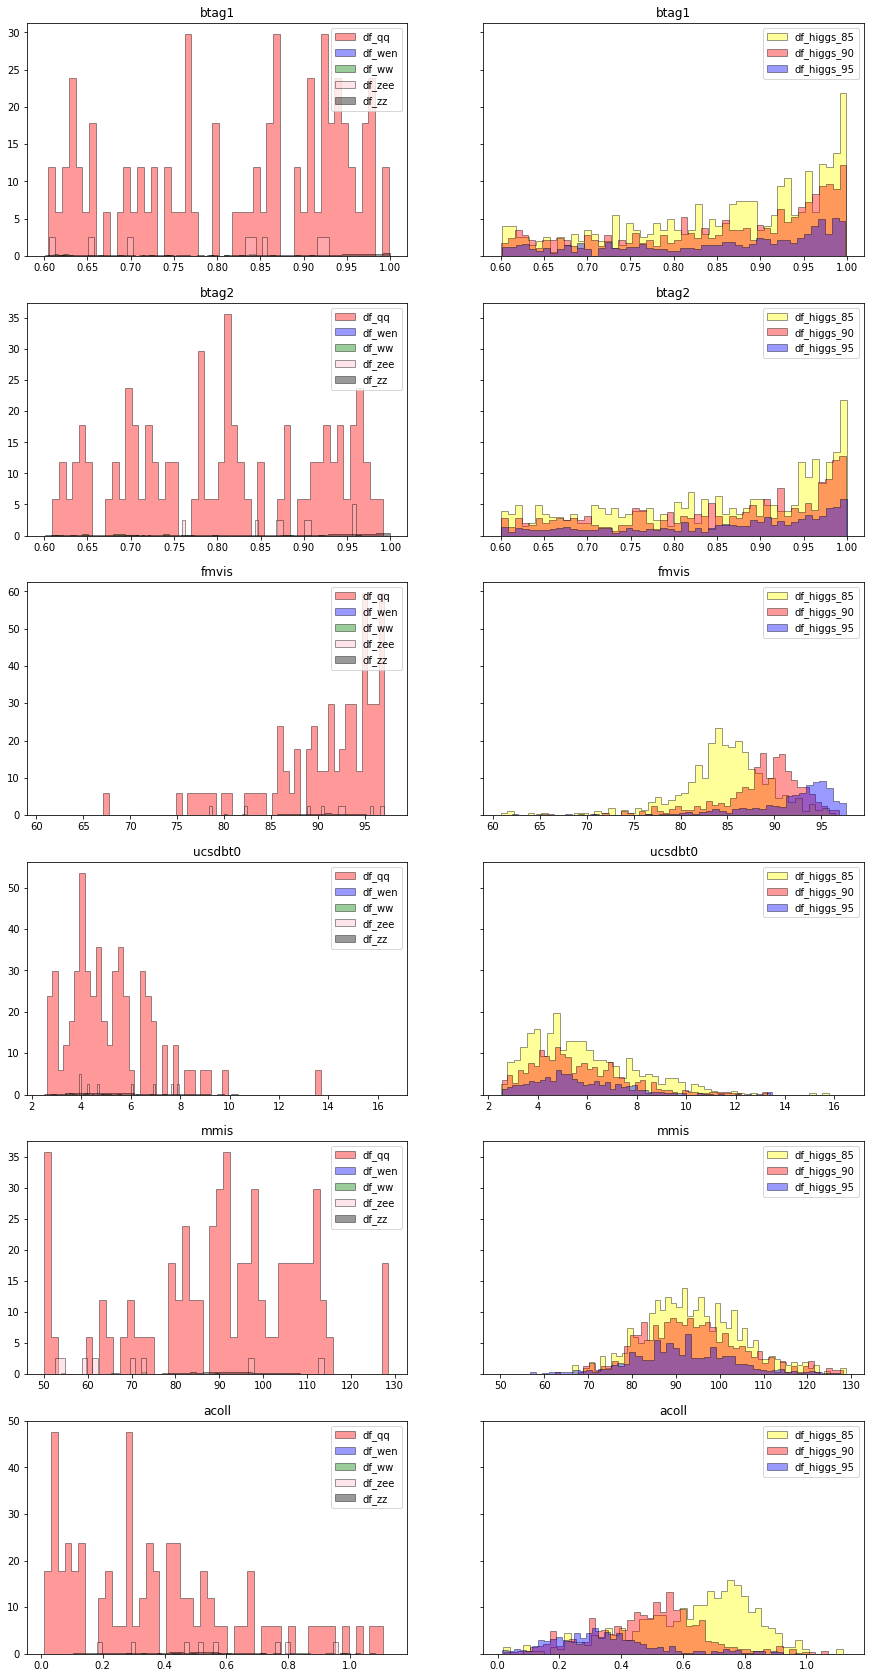

In [46]:
############################################################
# plot all variables for signal and background (WITH cuts) #
############################################################

#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['btag1', 'btag2', 'fmvis', 'ucsdbt0', 'mmis','acoll']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)
df_list_cut = []


f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

for dfname in df_names:
    index = df_names.index(dfname)
    tmpdf = (df_list[index])[(df_list[index])['btag1'] > 0.6]
    tmpdf = tmpdf[tmpdf['btag2'] > 0.6]
    tmpdf = tmpdf[tmpdf['ucsdbt0'] >2.5]
    tmpdf = tmpdf[tmpdf['fmvis'] >40]
    tmpdf = tmpdf[tmpdf['acoll'] < 65*np.pi/180]
    df_list_cut.append(tmpdf)


pumpsignal = 100    
nevents = [0]*len(df_list)


for varname in varlist:
    index_var = varlist.index(varname)
    for dfname in df_names:
        index = df_names.index(dfname)

        #backgrounds
        if bkgsigdata[index] == 'bkg':
            #plot histograms (normalised area to 1)
            #axs[index_var,0].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
            if(n_events(df_list_cut[index]) != 0):
                #calculate scale factor (xs) and plot histograms
                scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                axs[index_var,0].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                nevents[index]=((n_events(df_list_cut[index]))*scalef)
            else: 
                nevents[index]=0

        #signals
        if bkgsigdata[index] == 'sgn':
            #plot histograms (normalised area to 1)
            #axs[index_var,1].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

            #calculate scale factor (xs) and plot histograms
            if(n_events(df_list_cut[index]) != 0):
                scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
                weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
                axs[index_var,1].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
                nevents[index]=((n_events(df_list_cut[index]))*scalef)
            else: 
                nevents[index] = 0
    #plot title and legend for background (left) and signal (right)
    axs[index_var,0].set_title(varname)
    axs[index_var,0].legend(loc='best')
    axs[index_var,1].set_title(varname)
    axs[index_var,1].legend(loc='best')


plt.show()


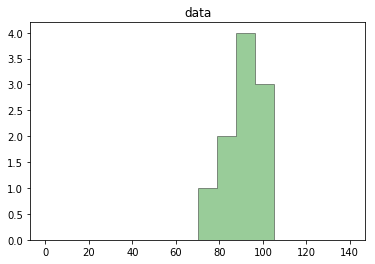

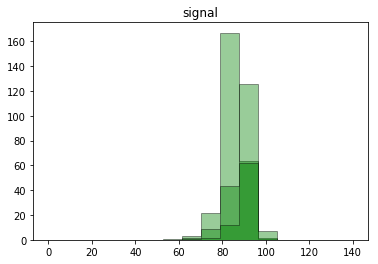

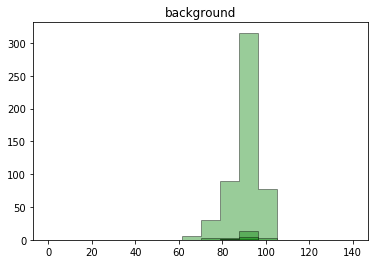

In [49]:
#######################
# log likelihood ploz #
#######################
   
df_list_cut = []

for dfname in df_names:
    index = df_names.index(dfname)
    tmpdf = (df_list[index])[(df_list[index])['btag1'] > 0.6]
    tmpdf = tmpdf[tmpdf['btag2'] > 0.6]
    tmpdf = tmpdf[tmpdf['ucsdbt0'] >2.5]
    tmpdf = tmpdf[tmpdf['fmvis'] >40]
    tmpdf = tmpdf[tmpdf['acoll'] < 65*np.pi/180]
    df_list_cut.append(tmpdf)

bins = np.linspace(0,140,17)


signal85_mh = []
signal90_mh = []
signal95_mh = []
backgr_mh = [0]*(len(bins)-1)
data_mh = []



pumpsignal = 100    
nevents = [0]*len(df_list)


for dfname in df_names:
    index = df_names.index(dfname)
    
    #data
    if bkgsigdata[index] == 'data':
        data_histo,bins_data,patches_data = plt.hist(((df_list_cut[index])['fmvis']), bins=bins, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

plt.title('data')
plt.show()

for dfname in df_names:
    index = df_names.index(dfname)

    #signals
    #signal with mh=85 GeV
    if index == 6:
        scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
        sgn_85,bins_sgn_85,patches_sgn_85 = plt.hist(((df_list_cut[index])['fmvis']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

    #signal with mh=90 GeV
    if index == 7:
        scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
        sgn_90,bins_sgn_90,patches_sgn_90 = plt.hist(((df_list_cut[index])['fmvis']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

    #signal with mh=95 GeV
    if index == 8:
        scalef = pumpsignal*scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
        sgn_95,bins_sgn_95,patches_sgn_95 = plt.hist(((df_list_cut[index])['fmvis']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

plt.title('signal')
plt.show()
    
for dfname in df_names:
    index = df_names.index(dfname)
    #backgrounds
    #SUM OVER
    if bkgsigdata[index] == 'bkg':
        if(n_events(df_list_cut[index]) != 0):
            #calculate scale factor (xs) 
            scalef = scalefactor(int_lumi, n_events(df_list[index]), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events(df_list_cut[index]), n_events(df_list_cut[index])))
            bkg,bins_bkg,patches_bkg = plt.hist(((df_list_cut[index])['fmvis']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
            backgr_mh = np.add(backgr_mh,bkg)

plt.title('background')
plt.show()

#calculate -2lnq
#backgr_mh
#sgn_
#data_histo

    


    
    


